In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

#email format
import email

#remove special characters
import re

#spaci -lemmatization-
import spacy

#cluster
from sklearn.cluster import KMeans  

# Getting the data
Enron Email dataset : contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages

source: https://www.cs.cmu.edu/~enron/

In [ ]:
#Load the Data set 
emailsDataFrame = pd.read_csv("../emails.csv") # mention path where dataset is stored on local machine
emailsDataFrame.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
#for testing only 10K emails will be processed
shortEmailsDataFrame = emailsDataFrame.truncate(after=9999)
print(shortEmailsDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     10000 non-null  object
 1   message  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None


# Sample Email Structure


In [ ]:
# raw data visualization to understand how the raw data looks like
shortEmailsDataFrame.loc[0]['message']

"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "

# Data Preparation

To facilitate the work with the data, only the most pertinent information will be extracted, in this case only the subject and the body of the message will be taken into account.

The text shown below is an example of the content found in the body of the message

In [ ]:
# to facilitate data manipulation, from the raw data will be extracted the 
# most important information

#transform a message in the newEmailsDataFrame into a workable format
# .items() shows the content of the email in the form key Value, in this way the 
# information contained in the email can be easily separated 

emailMessageBody = shortEmailsDataFrame.loc[32]['message']
emailMessageBody = email.message_from_string(emailMessageBody)
#emailMessageBody.items()
print(emailMessageBody.get_payload())

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/26/2000 
11:57 AM ---------------------------


"BS Stone" <bs_stone@yahoo.com> on 09/26/2000 04:47:40 AM
To: "jeff" <jeff@freeyellow.com>
cc: "Phillip K Allen" <Phillip.K.Allen@enron.com> 
Subject: closing



Jeff, 
?
Is the closing today?? After reviewing the  agreement?I find it isn't binding 
as far as I can determine.? It is  too vague and it doesn't sound like 
anything an attorney or title company  would?draft for a real estate 
closing--but, of course, I could be  wrong.? 
?
If this?closing is going to take place without  this agreement then there is 
no point in me  following up on this?document's validity.? 
?
I will just need to go back to my closing documents  and see what's there and 
find out where I am with that and deal with this as  best I can.
?
I guess I was expecting something that would be an  exhibit to a recordable 
document or something a little more exact, or  rather?sort of a contract.? 
This is

After extracting the subject and body of the message, it can be recognized that in the subject section there are several words that are constantly repeated because many emails are answered without changes in this section. Because of this, it will only work with the body of the message.

In [ ]:
#extract only Subject and Body to work with it
#the emails without Subject will be ignored

def estractSubjetAndBody(sourceDataFrame):
    msnTmp = None
    listTmp = []
    
    for i in range (len(sourceDataFrame)):
        msnTmp = sourceDataFrame.loc[i]['message']
        msnTmp = email.message_from_string(msnTmp)
        if msnTmp.get('Subject'):
            listTmp.append([msnTmp.get('Subject'),msnTmp.get_payload()])
    
    dataFrameTmp = pd.DataFrame(listTmp, columns=['Subject', 'Msn Body']) 
    return dataFrameTmp

topicBodyDataFrame = estractSubjetAndBody(shortEmailsDataFrame)
topicBodyDataFrame.head(6)

,Subject,Msn Body
0,Re:,Traveling to have a business meeting takes the...
1,Re: test,test successful. way to go!!!
2,Re: Hello,Let's shoot for Tuesday at 11:45.
3,Re: Hello,"Greg,\n\n How about either next Tuesday or Thu..."
4,Re: PRC review - phone calls,any morning between 10 and 11:30
5,Re: High Speed Internet Access,1. login: pallen pw: ke9davis\n\n I don't thi...


In [ ]:
#Control that all fields are filled
topicBodyDataFrame.isnull().any()

Subject     False
Msn Body    False
dtype: bool

# Data cleaning

After having a first impression of how the body of an email is composed, some parts of the text that are not important for the final result will be removed. these ports are:
* numbers
* special characters
* urls or E-mails
* blank spaces
* message header



In [ ]:
# As not all the words have the same importance and some symbols do not provide
# much meaning for the algorithm they must be eliminated, also all the words 
# have to look the same


def removeSpecialCharacters(rawString):
    regExpEmail = r'[\w\.-]+@[\w\.-]+'
    regExpHttp  =  r'http(s)?[:\/]+.+'
    regExpHeader = r'(---)+[\w\W\s]+(---)+'
    regExpNonAlphanumeric = r'[^a-zA-Z]'
    regExpWhiteSpace = r'([\s])+'
    
    
    #remove:
    # 1.) email adress
    rawString = re.sub(regExpEmail,"",rawString)
    
    # 2.) urls
    rawString = re.sub(regExpHttp,"",rawString)
    
     # 3.) header Forwarded
    rawString = re.sub(regExpHeader,"",rawString)
    
    # 4.) white spaces
    rawString = re.sub(regExpWhiteSpace," ",rawString)
    
    # 5.) non Alphanumeric characters
    rawString = re.sub(regExpNonAlphanumeric," ",rawString)
    
    # 6.) extra withe spaces
    rawString = " ".join(rawString.split())

    # 7.) lower case 
    rawString = rawString.lower()
    
    return rawString

def messagesGroup(sourceDataFrame):
    for i in range(len(sourceDataFrame.columns)):
        for j in range(len(sourceDataFrame)):
            strTmp = ""
            strTmp = sourceDataFrame.loc[j][i]
            sourceDataFrame.loc[j][i] = removeSpecialCharacters(strTmp)
    return sourceDataFrame

In [ ]:
#DataFrame after first cleaning step
topicBodyDataFrame = messagesGroup(topicBodyDataFrame)
topicBodyDataFrame.head(10)

,Subject,Msn Body
0,re,traveling to have a business meeting takes the...
1,re test,test successful way to go
2,re hello,let s shoot for tuesday at
3,re hello,greg how about either next tuesday or thursday...
4,re prc review phone calls,any morning between and
5,re high speed internet access,login pallen pw ke davis i don t think these a...
6,fw fixed forward or other collar floor gas pri...,buckner buck on pm to cc subject fw fixed forw...
7,re fw fixed forward or other collar floor gas ...,mr buckner for delivered gas behind san diego ...
8,consolidated positions issues to do list,allan severude pm to richard burchfield hou cc...
9,consolidated positions issues to do list,allan severude pm to richard burchfield hou cc...


In [ ]:
#setting up the stopwords set.
stopWordsSet = set(stopwords.words('english'))

#the stop words can be updated
stopWordsSet.update(['re:', 'cc', 'am', 'pm', 'hou', 'ect', 'fw', 'aa', 'aaa', 'nd', 'rd'])

def removeStopWords(sourceDataFrame):
    for i in range(len(sourceDataFrame.columns)):
        for j in range(len(sourceDataFrame)):
            tokens = word_tokenize(sourceDataFrame.loc[j][i])
            tokensWithoutSW = [w for w in tokens if not w in stopWordsSet]
            strTmp = ""
            strTmp = " ".join(tokensWithoutSW)
            sourceDataFrame.loc[j][i] = strTmp

removeStopWords(topicBodyDataFrame)

#DataFrame without Stopwords
topicBodyDataFrame.head(10)

,Subject,Msn Body
0,,traveling business meeting takes fun trip espe...
1,test,test successful way go
2,hello,let shoot tuesday
3,hello,greg either next tuesday thursday phillip
4,prc review phone calls,morning
5,high speed internet access,login pallen pw ke davis think required isp st...
6,fixed forward collar floor gas price terms,buckner buck subject fixed forward collar floo...
7,fixed forward collar floor gas price terms,mr buckner delivered gas behind san diego enro...
8,consolidated positions issues list,allan severude richard burchfield peggy alix r...
9,consolidated positions issues list,allan severude richard burchfield peggy alix r...


In [ ]:
#test blank fields
def deleteBlankFields(sourceDataFrame):
    listTmp = []
    for i in range(len(sourceDataFrame)):
        if len(sourceDataFrame.loc[i]['Subject']) and len(sourceDataFrame.loc[i]['Msn Body']):
            listTmp.append([sourceDataFrame.loc[i]['Subject'],sourceDataFrame.loc[i]['Msn Body']])
    
    dataFrameTmp = pd.DataFrame(listTmp, columns=['Subject', 'Msn Body']) 
    return dataFrameTmp

cleanedDataFrame = deleteBlankFields(topicBodyDataFrame)
cleanedDataFrame.info()

#debugging
#topicBodyDataFrame.loc[6][1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7275 entries, 0 to 7274
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   7275 non-null   object
 1   Msn Body  7275 non-null   object
dtypes: object(2)
memory usage: 113.8+ KB


Lemmatisation - grouping together the inflected forms of a word - helps reduce the total number of words that will be processed by the algorithm 

In [ ]:
def lemmatization(sourceDataFrame, allowed_postags=['NOUN','VERB','PROPN']):
    
    nlp = spacy.load("en_core_web_sm")
    text_out = []
    
    for i in range(len(sourceDataFrame.columns)):
        for j in range(len(sourceDataFrame)):
            
            doc = nlp(sourceDataFrame.loc[j][i])
            new_text = []
            
            for token in doc:
                if token.pos_ in allowed_postags:
                    new_text.append(token.lemma_)
            
            sourceDataFrame.loc[j][i] = " ".join(new_text)
    
lemmatization(topicBodyDataFrame) 
topicBodyDataFrame.head(10)


,Subject,Msn Body
0,,travel business meeting take trip prepare pres...
1,test,test way go
2,,let shoot tuesday
3,,greg tuesday thursday phillip
4,prc review phone call,morning
5,speed internet access,login pallen pw ke davis think require isp ip ...
6,fix collar floor gas price term,buckner buck subject fix collar floor gas pric...
7,fix collar floor gas price term,mr buckner deliver gas san diego enron energy ...
8,position issue list,allan severude richard burchfield peggy alix r...
9,position issue list,allan severude richard burchfield peggy alix r...


# Implementation

the preprocessing of the data is divided into three phases. 
* Bag of words
* Term frequency – inverse document frequency
* Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space

In [ ]:
#Plot a list of Words and their Value
def printTopWords(listWords, listValue, 
                  labX = 'Value', 
                  labY = 'Words',
                  title = 'Title'):
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(listWords))
    ax.barh(y_pos, listValue, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(listWords)
    ax.invert_yaxis()
    ax.set_xlabel(labX)
    ax.set_title("Top {} words {}".format(len(listWords),title))

#function to calculate the weights of TfIdf of the Data set
def createDocumentTermMatrix(sourceList, vectorizer):
    docTermVectorizer = vectorizer.fit_transform(sourceList)
    return (pd.DataFrame(docTermVectorizer.toarray(),columns=vectorizer.get_feature_names()), docTermVectorizer)


# Top most common words BOF

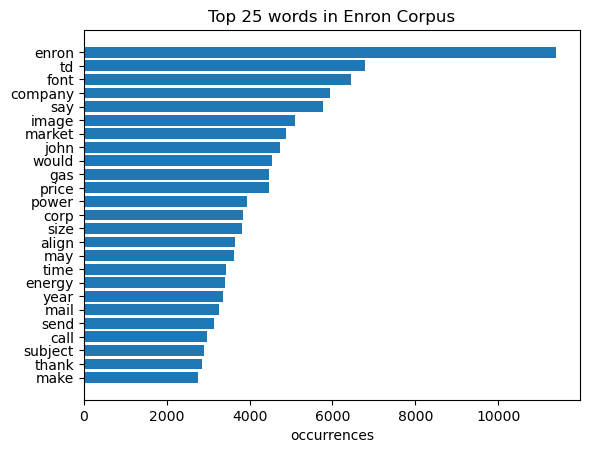

In [ ]:
# creation of a bag of words
#    myCountVectorizer => Dictionary
#    vectorBOW => matrix of token counts
#    bow => Dataframe with Bag of Words Matrix 

myCountVectorizer = CountVectorizer()
bow, vectorBOW = createDocumentTermMatrix(topicBodyDataFrame['Msn Body'],myCountVectorizer)

#make array from number of occurrences per Word
occurrences = np.asarray(vectorBOW.sum(axis=0)).ravel().tolist()

#make a new data frame with columns term and occurrences, meaning word and number of occurences
bowListFrame = pd.DataFrame({'term': myCountVectorizer.get_feature_names(), 'occurrences': occurrences})

#sort in order of number of word x=ces, most->leay=occuret. if you leave of ascending flag should default ASC
topWordsCorpa = bowListFrame.sort_values(by='occurrences', ascending=False).head(25)

printTopWords(topWordsCorpa['term'], topWordsCorpa['occurrences'], 
                  labX = 'occurrences', 
                  labY = 'Words count',
                  title = 'in Enron Corpus')


# Top most relevant words Tf-Idf

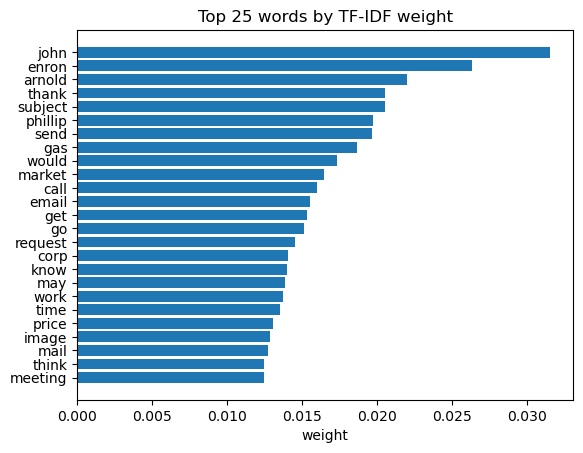

In [ ]:
#creation of a TF-IDF Matrix
myTfidfVectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix, vectorTFIDF = createDocumentTermMatrix(topicBodyDataFrame['Msn Body'],myTfidfVectorizer)

#follow similar process to making new data frame with word occurrences, but with term weights
emailWeights = np.asarray(vectorTFIDF.mean(axis=0)).ravel().tolist()

#now that we've done Tfid, make a dataframe with weights and names
emailWeightFrame = pd.DataFrame({'term': myCountVectorizer.get_feature_names(), 'weight': emailWeights})

topWeightCorpa = emailWeightFrame.sort_values(by='weight', ascending=False).head(25)

printTopWords(topWeightCorpa['term'], topWeightCorpa['weight'], 
                  labX = 'weight', 
                  labY = 'Words',
                  title = 'by TF-IDF weight')

# view by email - BoW

In [ ]:
#see the count of words in a E-mail
firstVectorBOW = vectorBOW[100]

vectorizedBOW = pd.DataFrame(firstVectorBOW.T.todense(), index=myCountVectorizer.get_feature_names(), columns=["score"]) 
vectorizedBOW = vectorizedBOW.sort_values(by=["score"],ascending=False)

vectorizedBOW.head(20)



,score
receive,1
know,1
need,1
closing,1
follow,1
look,1
date,1
matt,1
spoken,1
email,1


# view by email - Tf-Idf

In [ ]:
#see the most relevant words in a message

firstVectorTfidfvectorizer = vectorTFIDF[100] 

vectorizedDataFrame = pd.DataFrame(firstVectorTfidfvectorizer.T.todense(), index=myTfidfVectorizer.get_feature_names(), columns=["Tf-Idf Value"]) 
vectorizedDataFrame = vectorizedDataFrame.sort_values(by=["Tf-Idf Value"],ascending=False)

vectorizedDataFrame.head(20)

,Tf-Idf Value
lutz,0.420501
spoken,0.360710
brenda,0.298804
closing,0.296672
language,0.290755
suppose,0.278609
matt,0.253335
estimate,0.219789
jeff,0.187923
date,0.166349


# Linear dimensionality reduction

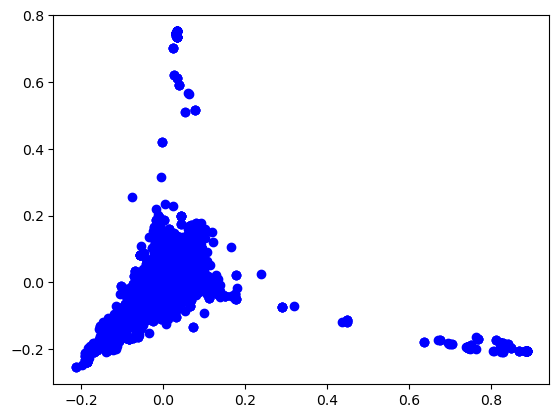

In [ ]:
# convert the mail bodies into a document-term matrix to visualise it. 
# This matrix is a 2d representation of the DTM (document-term matrix)
DTM_matrix = vectorTFIDF.todense()
coords = PCA(n_components=2).fit_transform(DTM_matrix)
plt.scatter(coords[:, 0], coords[:, 1], c = 'b')

# Kmeans 

In [ ]:
class Kmeans:
   
    
    def __init__(self, k, seed = None, max_iter = 200): #k : no of clusters
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    #randomly initialise centroids
    def initialise_centroids(self, data):
        
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    #Compute distance of data from clusters and assign data point to closest cluster
    def assign_clusters(self, data):
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    #Computes average of all data points in cluster and assigns new centroids as average of data points
    def update_centroids(self, data):
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    #Predict which cluster data point belongs to
    def predict(self, data):
     
        return self.assign_clusters(data)
    
    
    #This function contains the main loop to fit the algorithm
    #Implements initialise centroids and update_centroids according to max_iter
    
    def fit_kmeans(self, data):
        
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self   

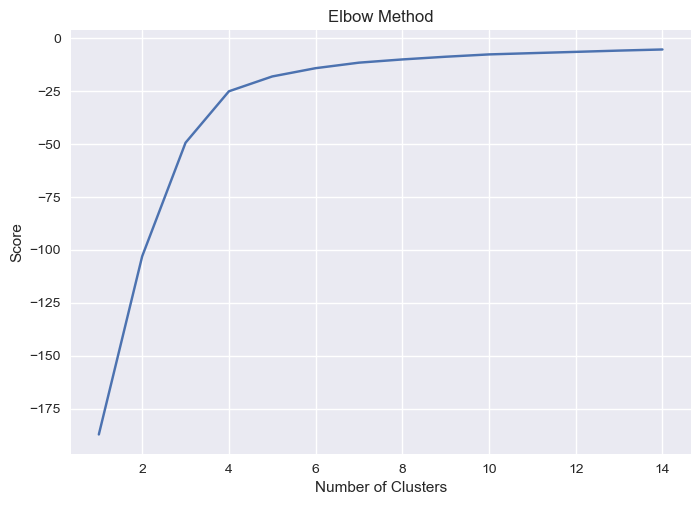

In [ ]:
#Elbow method to check optimum no clusters

number_clusters = range(1, 15)

kmeans = [KMeans(n_clusters=i, max_iter = 1000) for i in number_clusters]

score = [kmeans[i].fit(coords).score(coords) for i in range(len(kmeans))]

plt.style.use('seaborn')
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Running Model Iteration 600 
Running Model Iteration 700 
Running Model Iteration 800 
Running Model Iteration 900 
Model finished running


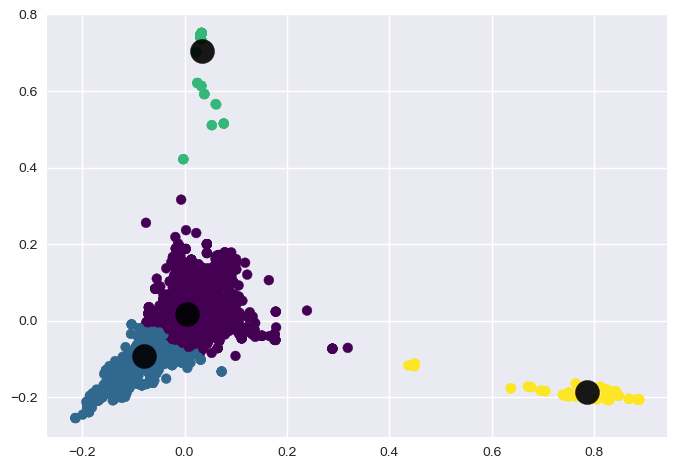

In [ ]:
#Object of Kmeans class 
test_e = Kmeans(4, 1, 1000)
fitted = test_e.fit_kmeans(coords)
predicted_values = test_e.predict(coords)

#plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')
plt.scatter(coords[:, 0], coords[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids

plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.9);

In [ ]:
# find the Top words in a cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = myTfidfVectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

tf_idf_norm = normalize(vectorTFIDF)
tf_idf_array = tf_idf_norm.toarray()
prediction = test_e.predict(coords)

dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

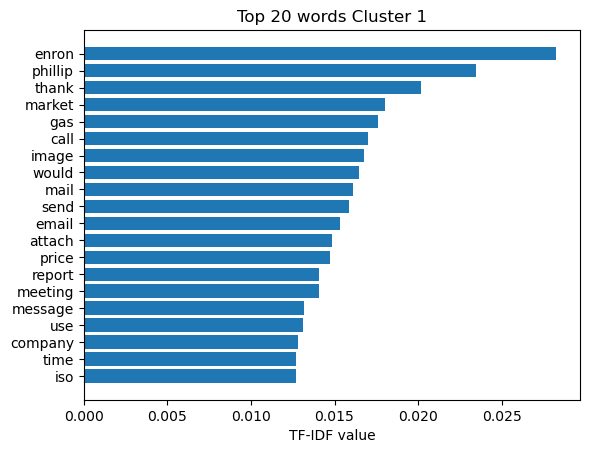

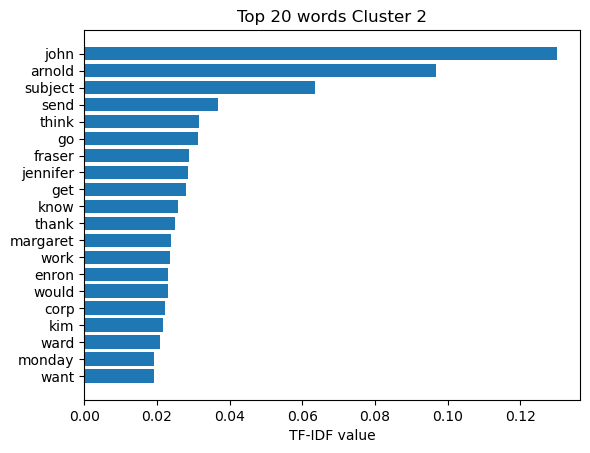

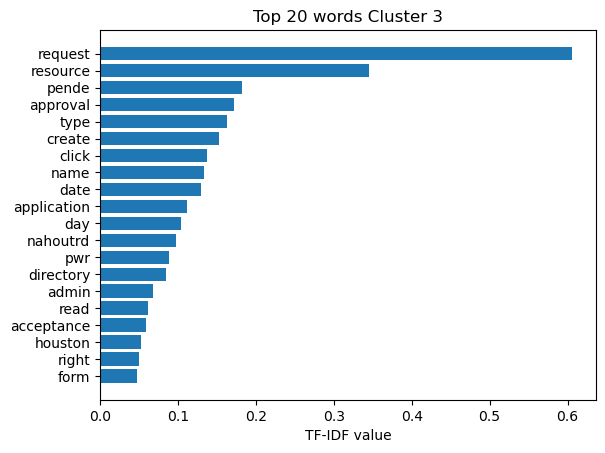

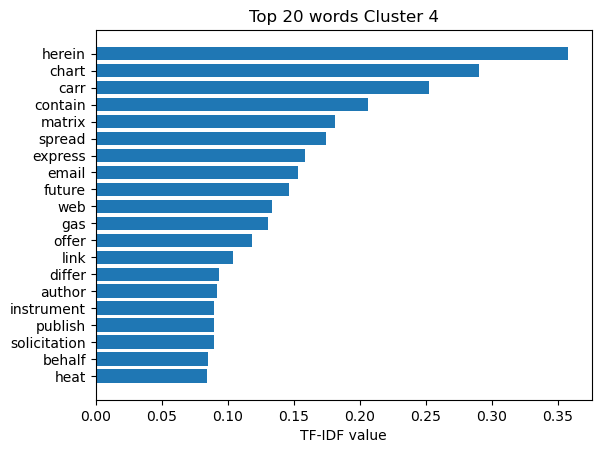

In [ ]:
# show sorting results
for i in range(len(dfs)):
    titulo = 'Cluster ' + str(i+1)
    printTopWords(dfs[i]['features'],dfs[i]['score'],labX='TF-IDF value',title = titulo)
